In [2]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    #plt.show()
    fig.canvas.draw()

In [4]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#https://drive.google.com/open?id=1rSXDPBolZnP5F0aWQdAGACwV-kZZXFbK
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1rSXDPBolZnP5F0aWQdAGACwV-kZZXFbK'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content "{}"'.format(downloaded.GetContentString()))

    100% |████████████████████████████████| 993kB 21.8MB/s 


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
downloaded.GetContentFile('processed_reviews.csv')

In [6]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [7]:
reviews_df=pd.read_csv('processed_reviews.csv')
reviews_df.head()

,processed_reviews,score
0,dogs love saw pet store tag attached regarding...,1
1,dogs loves chicken product china wont buying a...,0
2,bought local hardware store terrible fly probl...,0
3,many flies house product weeks stuck fly thus far,0
4,time spent waiting order fly traps arrive went...,0


In [0]:
reviews_df=reviews_df[reviews_df['processed_reviews']!='']

In [9]:
reviews_df[reviews_df['processed_reviews']=='']

,processed_reviews,score


In [0]:
reviews_df=reviews_df.dropna()

In [11]:
len(reviews_df)

103655

In [0]:
# Create vocabulary

all_text=''.join(reviews_df.processed_reviews.astype('str'))

In [0]:
# Find most common words
from collections import Counter
most_common_words=Counter(all_text.split()).most_common(40000)

In [14]:
most_common_words[:10]

[('not', 106111),
 ('like', 43181),
 ('good', 33199),
 ('one', 29911),
 ('taste', 29391),
 ('would', 27773),
 ('great', 27218),
 ('coffee', 25984),
 ('flavor', 24201),
 ('product', 23496)]

In [0]:
words,counts=list(zip(*most_common_words))

In [0]:
#convert words to index

from collections import defaultdict

In [0]:
def wrd_to_idx(words):
  word_to_idx=defaultdict(int)
  for i in range(len(words)):
    word_to_idx[words[i]]=i+1
   
  return word_to_idx

In [0]:
word_to_idx=wrd_to_idx(words)

In [19]:
word_to_idx['dogs']

85

In [0]:
#convert index to word
def idx_to_wrd(words):
  idx_to_wrd=defaultdict(str)
  
  for i in range(len(words)):
    idx_to_wrd[i+1]=words[i]
   
  return idx_to_wrd

In [0]:
idx_to_word=idx_to_wrd(words)

In [22]:
idx_to_word[1]

'not'

In [23]:
## Convert the text reviews into the respective indexes 

reviews=reviews_df['processed_reviews'].values
reviews[:10]

array(['dogs love saw pet store tag attached regarding made china satisfied safe',
       'dogs loves chicken product china wont buying anymore hard find chicken products made usa one isnt bad good product wont take chances till know going china imports',
       'bought local hardware store terrible fly problem trapped one fly year still hanging still one fly buy product',
       'many flies house product weeks stuck fly thus far',
       'time spent waiting order fly traps arrive went bought regular fly ribbon bad fly problem not sure kind flies slightly bigger fruit flies least week one fly traps caught zero flies fly trap caught probably flies regular fly ribbon one point even saw fly fly trap thought caught gone even pictures prove',
       'happy item many flies disturbing kitchen put product near window works fantastically',
       'hundreds common house flies hours not single one caught resorted fly swatter killed hours old fly swatter fly trap appears useless',
       'thing it

In [0]:
reviews_idx=[[word_to_idx[wrd] for wrd in sent.split() if wrd in words] for sent in reviews]

In [25]:
(reviews_idx[:2])

[[85, 15, 500, 433, 53, 3473, 3263, 2625, 44, 868, 907, 1051],
 [85,
  77,
  128,
  10,
  868,
  1958,
  142,
  783,
  120,
  25,
  128,
  105,
  44,
  1175,
  4,
  3698,
  116,
  3,
  10,
  1958,
  132,
  4513,
  1989,
  61,
  140,
  868,
  8030]]

In [0]:
# Split data into train and test
X_train=reviews_idx[:90000]
X_test=reviews_idx[90000:]
y_train=reviews_df.score[:90000]
y_test=reviews_df.score[90000:]

In [27]:
print(X_train[1])
print(type(X_train[1]))
print(len(X_train[1]))

[85, 77, 128, 10, 868, 1958, 142, 783, 120, 25, 128, 105, 44, 1175, 4, 3698, 116, 3, 10, 1958, 132, 4513, 1989, 61, 140, 868, 8030]
<class 'list'>
27


In [28]:
l=[len(x) for x in X_train]
max(l)

920

In [33]:
np.mean(l)

39.083133333333336

In [73]:
# truncate and/or pad input sequences
max_review_length = 100
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(90000, 100)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0   85   77  128   10  868 1958  142  783  120   25  128
  105   44 1175    4 3698  116    3   10 1958  132 4513 1989   61  140
  868 8030]


In [74]:
print(X_train[5000])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0   438   125  1196  1334    28  2794   203   414   109  3541
  1463  2696    16     1    33  1251     2   898    33    63    12    57
   638  4323    96   109     1   105  2102  1196   371  4421    28    93
   638     1   556     1  3372    10   472    25 13829 20805     6     1
    21   433 10281   296]


# 1 layer LSTM model

In [75]:
# create the model
top_words=30000
embedding_vecor_length = 100
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 100)          3000000   
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total params: 3,080,501
Trainable params: 3,080,501
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history=model.fit(X_train, y_train, nb_epoch=10, batch_size=64,validation_data=(X_test,y_test))
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
Use tf.cast instead.
Train on 80000 samples, validate on 23655 samples
Epoch 1/10
80000/80000 [==============================] - 580s 7ms/step - loss: 0.2374 - acc: 0.9060 - val_loss: 0.2098 - val_acc: 0.9138
Epoch 2/10
80000/80000 [==============================] - 573s 7ms/step - loss: 0.1581 - acc: 0.9395 - val_loss: 0.2091 - val_acc: 0.9180
Epoch 3/10
80000/80000 [==============================] - 571s 7ms/step - loss: 0.1220 - acc: 0.9548 - val_loss: 0.2308 - val_acc: 0.9155
Epoch 4/10
80000/80000 [==============================] - 578s 7ms/step - loss: 0.0949 - acc: 0.9658 - val_loss: 0.2322 - val_acc: 0.9144
Epoch 5/10
80000/80000 [==============================] - 577s 7ms/step - loss: 0.0747 - acc: 0.9734 - val_loss: 0.2528 - val_acc: 0.9086
Epoch 6/10
80000/80000 [==============================] - 577s 7ms/step - loss: 0.0573 - acc: 0.9801 - val_loss: 0.3391 - val_acc: 0.9077
Epoch 7/10
80000/80000 [==============================] - 571s 7ms/step - 

Test accuracy of model is 90.52 %

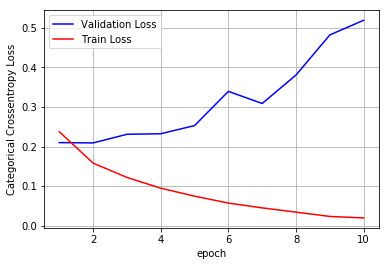

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,10+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

We see that, test loss is diverging from the train loss. Thus , our model is heavily overfitted. Let us try to reduce the overfitting. by using dropout and less no of LSTM cells

# 1 Layer LSTM with Dropout (Variational RNN)

In [76]:
# create the model
top_words=40000
embedding_vecor_length = 100
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
#model.add(LSTM(64,dropout=0.6, recurrent_dropout=0.6))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 100)          4000000   
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 4,117,377
Trainable params: 4,117,377
Non-trainable params: 0
_________________________________________________________________
None


In [77]:
history=model.fit(X_train, y_train, nb_epoch=25, batch_size=512,validation_data=(X_test,y_test))
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 90000 samples, validate on 13655 samples
Epoch 1/25
90000/90000 [==============================] - 46s 515us/step - loss: 0.5481 - acc: 0.8377 - val_loss: 0.4743 - val_acc: 0.8349
Epoch 2/25
90000/90000 [==============================] - 43s 478us/step - loss: 0.4500 - acc: 0.8402 - val_loss: 0.4489 - val_acc: 0.8349
Epoch 3/25
90000/90000 [==============================] - 43s 479us/step - loss: 0.4401 - acc: 0.8402 - val_loss: 0.4478 - val_acc: 0.8349
Epoch 4/25
90000/90000 [==============================] - 43s 479us/step - loss: 0.4395 - acc: 0.8402 - val_loss: 0.4477 - val_acc: 0.8349
Epoch 5/25
90000/90000 [==============================] - 43s 474us/step - loss: 0.4395 - acc: 0.8402 - val_loss: 0.4477 - val_acc: 0.8349
Epoch 6/25
90000/90000 [==============================] - 42s 470us/step - loss: 0.4392 - acc: 0.8402 - val_loss: 0.4476 - val_acc: 0.8349
Epoch 7/25
90000/90000 [==============================] - 43s 474us/step - loss: 0.4393 - acc: 0.8402 - val_loss: 0.

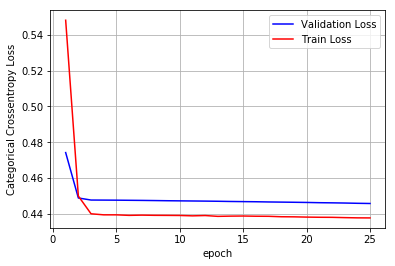

In [78]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,25+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

# 2 Layer LSTM model

In [30]:
# create the model
top_words=30000
embedding_vecor_length = 50
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 50)           1500000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 32)           10624     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,513,777
Trainable params: 1,513,777
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
history=model.fit(X_train, y_train, nb_epoch=15, batch_size=64,validation_data=(X_test,y_test))
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
Use tf.cast instead.
Train on 80000 samples, validate on 23655 samples
Epoch 1/15
80000/80000 [==============================] - 1136s 14ms/step - loss: 0.2817 - acc: 0.8848 - val_loss: 0.2330 - val_acc: 0.9044
Epoch 2/15
80000/80000 [==============================] - 1119s 14ms/step - loss: 0.1745 - acc: 0.9327 - val_loss: 0.2172 - val_acc: 0.9163
Epoch 3/15
80000/80000 [==============================] - 1113s 14ms/step - loss: 0.1413 - acc: 0.9460 - val_loss: 0.2126 - val_acc: 0.9158
Epoch 4/15
80000/80000 [==============================] - 1107s 14ms/step - loss: 0.1190 - acc: 0.9559 - val_loss: 0.2320 - val_acc: 0.9111
Epoch 5/15
80000/80000 [==============================] - 1120s 14ms/step - loss: 0.1003 - acc: 0.9638 - val_loss: 0.2643 - val_acc: 0.9074
Epoch 6/15
80000/80000 [==============================] - 1108s 14ms/step - loss: 0.0819 - acc: 0.9714 - val_loss: 0.2705 - val_acc: 0.9116
Epoch 7/15
80000/80000 [==============================] - 1102

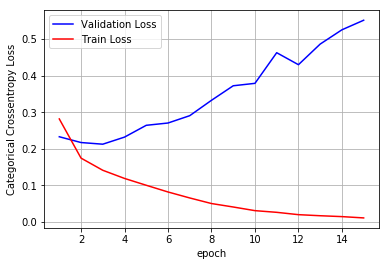

In [33]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,15+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [0]:
from keras.layers import  Dropout

In [79]:
# create the model
top_words=40000
embedding_vecor_length = 300
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(32,return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 300)          12000000  
_________________________________________________________________
lstm_14 (LSTM)               (None, 100, 32)           42624     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100, 32)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 12,050,977
Trainable params: 12,050,977
Non-trainable params: 0
________________________________________________________________

In [80]:
history=model.fit(X_train, y_train, nb_epoch=25, batch_size=512,validation_data=(X_test,y_test))
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 90000 samples, validate on 13655 samples
Epoch 1/25
90000/90000 [==============================] - 85s 944us/step - loss: 0.5307 - acc: 0.8367 - val_loss: 0.4623 - val_acc: 0.8349
Epoch 2/25
90000/90000 [==============================] - 80s 889us/step - loss: 0.4474 - acc: 0.8402 - val_loss: 0.4485 - val_acc: 0.8349
Epoch 3/25
90000/90000 [==============================] - 80s 889us/step - loss: 0.4426 - acc: 0.8402 - val_loss: 0.4481 - val_acc: 0.8349
Epoch 4/25
90000/90000 [==============================] - 80s 884us/step - loss: 0.4426 - acc: 0.8402 - val_loss: 0.4481 - val_acc: 0.8349
Epoch 5/25
90000/90000 [==============================] - 79s 873us/step - loss: 0.4425 - acc: 0.8402 - val_loss: 0.4480 - val_acc: 0.8349
Epoch 6/25
90000/90000 [==============================] - 79s 873us/step - loss: 0.4419 - acc: 0.8402 - val_loss: 0.4479 - val_acc: 0.8349
Epoch 7/25
90000/90000 [==============================] - 78s 871us/step - loss: 0.4416 - acc: 0.8402 - val_loss: 0.

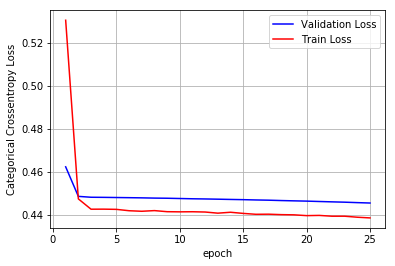

In [81]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,25+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [1]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Layers",'Model','Optimiser','Dropout',"Test Accuracy"]
x.add_row(["1","LSTM",'adam','-', "90.52%"])
x.add_row(["1","LSTM",'sgd',0.2, "83.49%"])
x.add_row(["2","LSTM",'adam','-', "88.88%"])
x.add_row(["2","LSTM",'sgd',0.3, "83.49%"])
print(x)

+--------+-------+-----------+---------+---------------+
| Layers | Model | Optimiser | Dropout | Test Accuracy |
+--------+-------+-----------+---------+---------------+
|   1    |  LSTM |    adam   |    -    |     90.52%    |
|   1    |  LSTM |    sgd    |   0.2   |     83.49%    |
|   2    |  LSTM |    adam   |    -    |     88.88%    |
|   2    |  LSTM |    sgd    |   0.3   |     83.49%    |
+--------+-------+-----------+---------+---------------+


 We see that models with adam optimiser and without dropout have high accuracy but overfit a lot, whereas models with sgd optimiser and dropout have low accuracy but do not overfit.

Steps we followed for data processing and model creation:

* Get 100k preprocessed reviews and put them in a csv along with the sentiment.
* Upload the reviews csv to colab and use it in colab for modelling.
* Get the most common words in the processed reviews.
* Create a vocab of most common words by converting words into integers.
* Convert the reviews into sequence of integers using the vocab.
* Use the sequence as input to our LSTM model as embedding layer.
* Run a 1 layer and a 2 Layer LSTM model.
* Check accuracy of our models.